Notebook from kaggle by Ayushman Buragohain

In [1]:
import sys
sys.path.append('../input/timmmodels/pytorch-image-models')

!git clone https://github.com/benihime91/leaf-disease-classification-kaggle.git
!wandb login a74f67fd5fae293e301ea8b6710ee0241f595a63

Cloning into 'leaf-disease-classification-kaggle'...
remote: Enumerating objects: 292, done.
remote: Counting objects: 100% (292/292), done.
remote: Compressing objects: 100% (193/193), done.
remote: Total 669 (delta 183), reused 187 (delta 85), pack-reused 377
Receiving objects: 100% (669/669), 9.04 MiB | 14.26 MiB/s, done.
Resolving deltas: 100% (386/386), done.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [2]:
import os
import wandb
import albumentations as A

from fastai.vision.all import *
from fastai.callback.wandb import *
from fastai.callback.cutmix import CutMix

import logging
logger = logging.getLogger("wandb")
logger.setLevel(logging.ERROR)

For the sake of simplicity, we will borrow from `timm` lib and `cassava_utils` script

In [3]:
import timm
from cassava_utils import *

In [4]:
SEED        = 42
IDX         = generate_random_id()
OOF_FOLD    = 0
NUM_CLASSES = 5
CSV_PATH    = './leaf-disease-classification-kaggle/data/fold_df.csv'
IMAGE_DIR   = '../input/cassava-leaf-disease-classification/train_images/'
INPUT_DIMS  = 224
MODEL       = 'tf_efficientnet_b3'
PROJECT     = 'kaggle-leaf-disease-fastai-runs'
SAVE_NAME   = f"{MODEL}-fold={OOF_FOLD}-{IDX}"

set_seed(SEED, reproducible=True)

run = wandb.init(project=PROJECT, tags=[MODEL, 'ranger', 'mixup', 'gradual-training'], 
                notes="Efficientnet_b3 + Ranger + Flatten Anneal (Gradual) + MixUp", )

wandb: Currently logged in as: ayushman (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.12 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Our dataset today will be the data from kaggle's [Cassava Leaf Disease Classification](https://www.kaggle.com/c/cassava-leaf-disease-classification).

Goal : using pretrained models , see how well of accuracy we can get in x epochs for the OOF validation dataset.

Pretrained models are loaded mainly from the `timm` library.

In [5]:
data = get_dataset(CSV_PATH, IMAGE_DIR, OOF_FOLD, shuffle=True)
data.head()

,image_id,label,filePath,kfold,is_valid
0,1587173996.jpg,Healthy,../input/cassava-leaf-disease-classification/train_images/1587173996.jpg,2,False
1,404115232.jpg,Cassava Mosaic Disease (CMD),../input/cassava-leaf-disease-classification/train_images/404115232.jpg,0,True
2,3945098769.jpg,Cassava Mosaic Disease (CMD),../input/cassava-leaf-disease-classification/train_images/3945098769.jpg,1,False
3,4037735151.jpg,Cassava Mosaic Disease (CMD),../input/cassava-leaf-disease-classification/train_images/4037735151.jpg,3,False
4,730805822.jpg,Cassava Mosaic Disease (CMD),../input/cassava-leaf-disease-classification/train_images/730805822.jpg,1,False


In [6]:
TRAIN_AUGS = A.Compose([
    A.OneOf([A.RandomResizedCrop(INPUT_DIMS, INPUT_DIMS), A.CenterCrop(INPUT_DIMS, INPUT_DIMS)], p=0.5),
    A.Resize(INPUT_DIMS, INPUT_DIMS, p=1.0),
    A.OneOf([A.HorizontalFlip(), A.Rotate(60)]),
    A.OneOf([A.Flip(),A.IAAPerspective(), A.ShiftScaleRotate(),],p=0.5),
    A.OneOf([A.CLAHE(),A.HueSaturationValue(0.2, 0.2, 0.2, p=0.4), A.RandomBrightnessContrast(0.1, 0.1, p=0.5),], p=0.5),
    A.CoarseDropout(p=0.5),
    A.Cutout(p=0.5), 
])

VALID_AUGS = A.Compose([A.Resize(INPUT_DIMS, INPUT_DIMS, p=1.0)], p=1.)

ITEM_TFMS  = AlbumentationsTransform(TRAIN_AUGS, VALID_AUGS)
BATCH_TFMS = [Normalize.from_stats(*imagenet_stats)]

dls = get_dataloaders(data, ITEM_TFMS, BATCH_TFMS)

Let's view some images from the dataset for sanity check

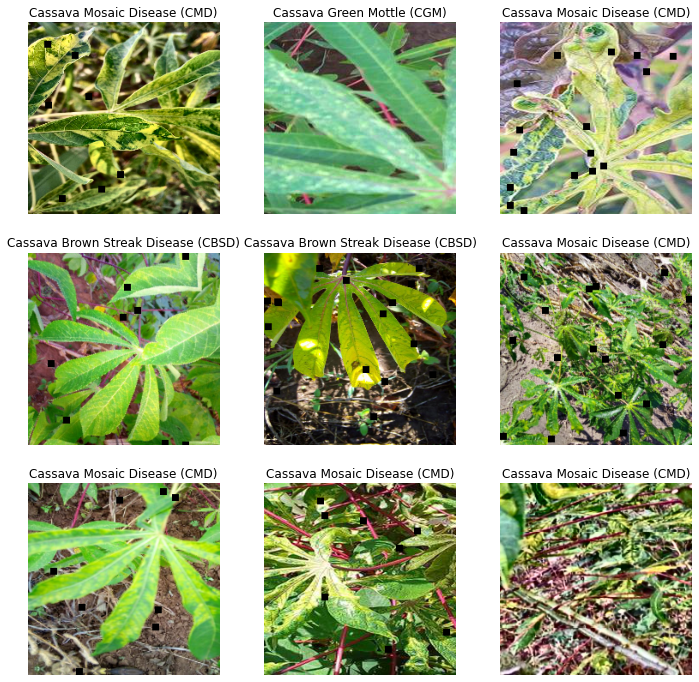

In [7]:
dls.show_batch(figsize=(12, 12))

For pretrained models we will working out of Ross Wightman's. Included in this repository is tons of pretrained models for almost every major model in Computer Vision.

The function below loads a custom model from the `timm` library using the name of the model and prepares it for transfer via fastai `Learner`.

In [8]:
@delegates(Learner)
def timm_learner(dls, m_name:str, cut:int, c:int, state:str=None, 
                pretrained:bool=True, act:callable=nn.ReLU(inplace=True), **kwargs):
    'create a fast.ai learner instance from timm'
    encoder = timm.create_model(m_name, pretrained=pretrained)
    model  = TransferLearningModel(encoder, num_classes=c, cut=cut, act=act)
    
    if state is not None: model.load_state_dict(torch.load(state))
    
    learn = Learner(dls, model, **kwargs)
    return learn

## Efficientnet_b3 + Ranger + Flatten Anneal (Gradual) + MixUp

In [9]:
learn = timm_learner(dls, MODEL, -2, dls.c, wd=1e-2, metrics=[accuracy],
                    opt_func=ranger, splitter=custom_splitter,
                    loss_func=LabelSmoothingCrossEntropy(),
                    cbs=[WandbCallback(seed=SEED, log_preds=False, log_model=False)]).to_native_fp16()

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b3_aa-84b4657e.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b3_aa-84b4657e.pth


In [ ]:
learn.model

In [ ]:
learn.freeze()
learn.lr_find()

In [ ]:
learn.fit_flat_cos(4, slice(2e-03), pct_start=0.9, cbs=[MixUp(0.7)])
learn.save('stage-1')

In [ ]:
learn = learn.load('stage-1')

In [ ]:
learn.unfreeze()
learn.lr_find()

In [ ]:
learn.unfreeze()
base_lr = 1e-03
learn.fit_flat_cos(10, slice(base_lr/100, base_lr), pct_start=0.3, cbs=[MixUp(0.2)], wd=0.1)

In [ ]:
learn.save('stage-2')

Let's upload the models weights to `wandb`

In [ ]:
learn = learn.load('stage-2')
learn = learn.to_native_fp32() # port model back to fp_32

In [ ]:
save_dir = f"/kaggle/working/{SAVE_NAME}.pt"
torch.save(learn.model.state_dict(), save_dir)
wandb.save(save_dir)
wandb.finish()